# Classification Toy Problem

In this turorial, we will learn how to do classification using MLP. The codes are running under Python 2.7+ with MXNet.

First let's import the modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx

## 1. Network Definition

Then, we define a 2-layer MLP in a flavour of symbolic programming provided by MXNet. The rough graph of the network will be displayed after running following codes.

Here we set the number of classes to 3 for example.

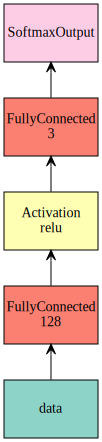

In [2]:
num_classes = 3
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=num_classes)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net)

The free variables include the weight and the bias from each fully connected layer (fc1 and fc2), the example for variable data, and the label for the softmax output out. We list all these variables' name by list_argument:

In [3]:
net.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'out_label']

To run forward and backward, we need to bind data to all free variables first.

In [4]:
num_features = 2
num_samples = num_classes * 100
ex = net.simple_bind(ctx=mx.cpu(), data=(num_samples, num_features))
args = dict(zip(net.list_arguments(), ex.arg_arrays))
for name in args:
    print(name, args[name].shape)

('fc2_weight', (3L, 128L))
('fc1_weight', (128L, 2L))
('out_label', (300L,))
('fc2_bias', (3L,))
('data', (300L, 2L))
('fc1_bias', (128L,))


## 2. Training Data Generation

After constructting the network and initialize the weights, let's generate some training data. Here, we define a ToyData class to generate training data randomly. Every time you run these code, you a different group of three classes with random means(mu) and variances(sigma).

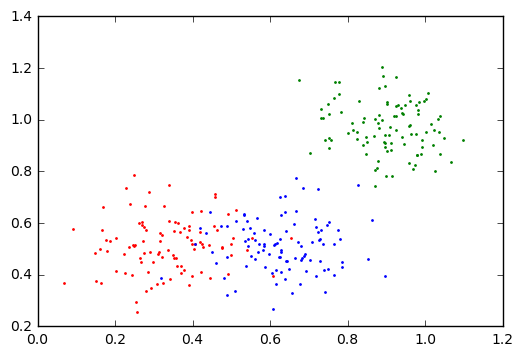

In [5]:
class ToyData:
    def __init__(self, num_classes, num_features):
        self.num_classes = num_classes
        self.num_features = num_features
        self.mu = np.random.rand(num_classes, num_features)
        self.sigma = np.ones((num_classes, num_features)) * 0.1
    def get(self, num_samples):
        num_cls_samples = num_samples / self.num_classes
        x = np.zeros((num_samples, self.num_features))
        y = np.zeros((num_samples, ))
        for i in range(self.num_classes):
            cls_samples = np.random.normal(self.mu[i,:], self.sigma[i,:], (num_cls_samples, self.num_features))
            x[i*num_cls_samples:(i+1)*num_cls_samples] = cls_samples
            y[i*num_cls_samples:(i+1)*num_cls_samples] = i
        return x, y
    def plot(self, x, y):
        colors = ['r', 'b', 'g']
        for i in range(self.num_classes):
            cls_x = x[y == i]
            plt.scatter(cls_x[:,0], cls_x[:,1], color=colors[i%3], s=1)
        plt.show()

toy_data = ToyData(num_classes, num_features)
x, y = toy_data.get(num_samples)
toy_data.plot(x,y)

## 3. Network Training

Train the MLP network. As the MXNet will calculate the gradients automatically, you just need to use them to update your weight directly in backward procedures.

Pay attention to the change of accuracy after each iteration.

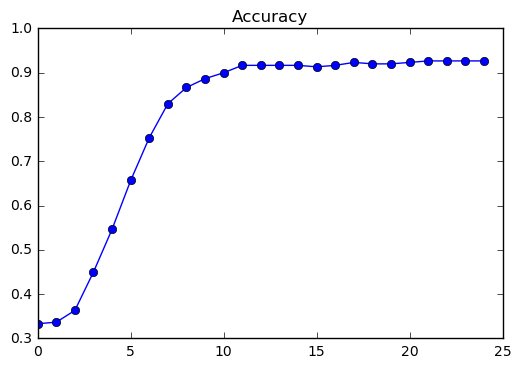

In [6]:
# Initialize the weights by random values.
for name in args:
    data = args[name]
    if 'weight' in name:
        data[:] = mx.random.uniform(-0.1, 0.1, data.shape)
    if 'bias' in name:
        data[:] = 0

acc_history = []
learning_rate = 0.1
num_epoch = 500
for i in range(num_epoch):
    args['data'][:] = x
    args['out_label'][:] = y
    ex.forward(is_train=True)
    ex.backward()
    for weight, grad in zip(ex.arg_arrays, ex.grad_arrays):
        weight[:] -= learning_rate * (grad / num_samples)
    if i % 20 == 0:
        acc = (mx.nd.argmax_channel(ex.outputs[0]).asnumpy() == y).sum()
        # print('epoch %d, accuracy %f' % (i, float(acc)/y.shape[0]))
        acc_history.append(float(acc)/y.shape[0])

plt.title('Accuracy')
plt.plot(acc_history, '-o', label='train')

(0.056163675297960403, 1.3994450393169811)

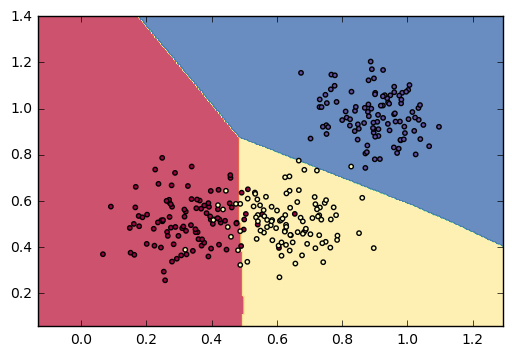

In [7]:
# plot the resulting classifier
count = 100 * num_classes
x_min, x_max = x[:, 0].min() - 0.2, x[:, 0].max() + 0.2
y_min, y_max = x[:, 1].min() - 0.2, x[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/count),
                     np.arange(y_min, y_max, (y_max - y_min)/count))
cords = np.c_[xx.ravel(), yy.ravel()]

data_row = args['data'].shape[0]
Z = np.zeros(count**2)
for i in range(count**2 / data_row):
    tmp_data = cords[range(i*data_row, (i+1)*data_row), :]
    ex.forward(is_train=True, data=tmp_data)
    Z[range(i*data_row, (i+1)*data_row)] = mx.nd.argmax_channel(ex.outputs[0]).asnumpy()
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(x[:, 0], x[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')